# Using Genestack Omics APIs for single-cell analysis

### Set instance and token

In [1]:
library(studyCurator)
suppressMessages(library(tidyverse))
suppressMessages(library(integrationCurator)) # Genestack client library

Sys.setenv(PRED_SPOT_HOST = 'occam.genestack.com',
           PRED_SPOT_TOKEN = '<token>',
           PRED_SPOT_VERSION = 'default-released')

### Get study

In [2]:
study_filter = sprintf('genestack:accession=GSF766955')

study = as_tibble(StudySPoTApi_search_studies(
        filter = study_filter)$content$data)
study

genestack:accession,Study Source,Study Source ID,Study Description,Study Type,Study Design,Therapeutic Area,Contributor,Contributor Email,Release Date,Last Update Date,Raw Data Files,Processed Data Files,Processed Data Matrix Files,Import Source URL,Database Source URL,Study Title,Cell Metadata File
GSF766955,ArrayExpress,E-MTAB-6149,"This is a 52,698-cell catalogue of the tumour microenvironment (TME) transcriptome in human lung tumorrs at single-cell resolution, validated in independent patient samples where 40,250 additional cells were sequenced. By comparing with matching non-malignant lung samples, the authors revealed a highly complex TME that profoundly molds stromal cells. They identified 52 stromal cell subtypes, including novel subpopulations in cell types hitherto considered to be homogeneous, as well as transcription factors underlying their heterogeneity.",Single-cell RNA-Seq,NA,Oncology,Diether Lambrechts,diether.lambrechts@kuleuven.vib.be,,,NA,NA,NA,NA,NA,E-MTAB-6149,https://bio-test-data.s3.amazonaws.com/E-MTAB-6149/cell_metadata.tsv


### Get samples

In [3]:
sample_filter='Disease="lung squamous cell carcinoma" AND Tissue=Lung'

start = Sys.time()
samples <- as_tibble(OmicsQueriesApi_search_samples(
    study_filter=study_filter,
    sample_filter=sample_filter,
    page_limit = 20000
)$content$data[['metadata']])
cat(sprintf('Time to get %s samples: %s seconds\n\n', nrow(samples), round(Sys.time()-start)))

head(samples)

Time to get 7 samples: 0 seconds



genestack:accession,Sample Source ID,Sample Name,Organism,Disease,Tissue,Cell Type,Cell Line,Sampling Site,Age,...,Smoking Status,Stage,fastq,Sample,Patient,Sample Source,ID in Array Express,Carcinoma Type,Affected Lobe,seq ID
GSF766961,2-middle,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,NA,86,...,Former,IB,BT2A,5,2,ArrayExpress,2a,Squamous,Right upper,"BT1244 , BT1245"
GSF766962,2-edge,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,NA,86,...,Former,IB,BT2B,6,2,ArrayExpress,2b,Squamous,Right upper,"BT1246, BT1248"
GSF766963,2-normal,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,NA,86,...,Former,IB,BT1247,7,2,ArrayExpress,2d,Squamous,Right upper,NA
GSF766957,1-core,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,NA,70,...,Active,IIA,BT1A,1,1,ArrayExpress,1a,Squamous,Left upper,"BT1238, BT1239"
GSF766958,1-middle,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,NA,70,...,Active,IIA,BT1B,2,1,ArrayExpress,1b,Squamous,Left upper,"BT1240, BT1241"
GSF766959,1-edge,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,NA,70,...,Active,IIA,BT1C,3,1,ArrayExpress,1c,Squamous,Left upper,"BT1242, BT1243"


### Get cell metadata

In [5]:
start = Sys.time()
cell_metadata_file = url(study[['Cell Metadata File']])
cell_metadata = read.table(
      cell_metadata_file,
      sep = "\t",
      header = TRUE,
      stringsAsFactors = FALSE,
      check.names=FALSE
    )

cell_metadata[['Barcode']] = paste(cell_metadata[['Lane']], cell_metadata[['Barcode']], sep = '/')
samples = samples %>% select(-one_of('Cell Type'))
samples = inner_join(samples, cell_metadata, by=c("Sample Source ID"="Lane"))
cat(sprintf('Time to get metadata for %s cells: %s seconds\n\n', nrow(samples), round(Sys.time()-start)))

head(samples)

Time to get metadata for 4314 cells: 2 seconds



genestack:accession,Sample Source ID,Sample Name,Organism,Disease,Tissue,Cell Line,Sampling Site,Age,Age Unit,...,Patient,Sample Source,ID in Array Express,Carcinoma Type,Affected Lobe,seq ID,Barcode,Cell Type,x,y
GSF766961,2-middle,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,86,NA,...,2,ArrayExpress,2a,Squamous,Right upper,"BT1244 , BT1245",2-middle/AGTTCTACGCATAC-1,Alveolar,-0.0975911,35.19166
GSF766961,2-middle,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,86,NA,...,2,ArrayExpress,2a,Squamous,Right upper,"BT1244 , BT1245",2-middle/ATACCGGATCGTGA-1,Alveolar,0.9450912,35.80172
GSF766961,2-middle,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,86,NA,...,2,ArrayExpress,2a,Squamous,Right upper,"BT1244 , BT1245",2-middle/ATATACGATGCCCT-1,Alveolar,1.9929145,26.83917
GSF766961,2-middle,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,86,NA,...,2,ArrayExpress,2a,Squamous,Right upper,"BT1244 , BT1245",2-middle/GAACGTTGATGGTC-1,Alveolar,0.8190789,39.46808
GSF766961,2-middle,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,86,NA,...,2,ArrayExpress,2a,Squamous,Right upper,"BT1244 , BT1245",2-middle/TCAGACGAGCAAGG-1,Alveolar,0.4830626,32.60758
GSF766961,2-middle,NA,Homo sapiens,lung squamous cell carcinoma,lung,NA,NA,86,NA,...,2,ArrayExpress,2a,Squamous,Right upper,"BT1244 , BT1245",2-middle/GCACGGTGTAACCG-1,Alveolar,8.1193446,41.27375


### t-SNE Plot

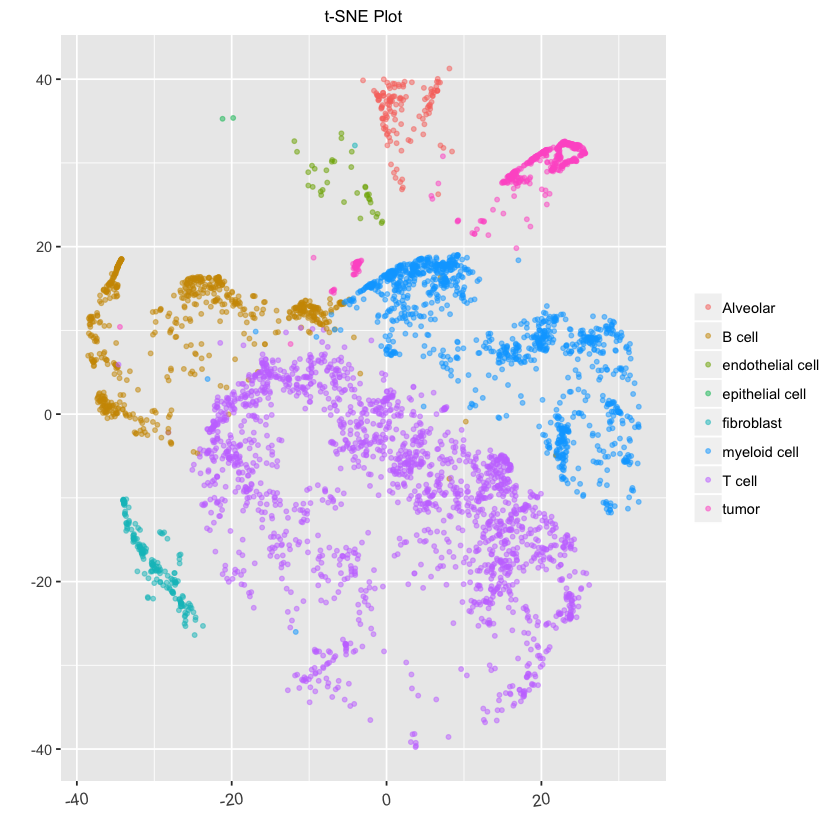

In [6]:
ggplot(samples, mapping=aes(x=x, y=y, color=`Cell Type`)) +
        geom_point(cex=1, alpha=0.5) +
        theme(axis.text.x = element_text(size = 10, angle = 8, hjust = 0.5, vjust = 0.5)) +
        theme(legend.title = element_blank()) + labs(y = "", x = "") +
        ggtitle('t-SNE Plot') + theme(plot.title = element_text(hjust = 0.5, size=10))

### Get expression data

In [7]:
gene = 'CD79A'
ex_query = sprintf('Gene=%s MinValue=0', gene)

start = Sys.time()
expressions <- as_tibble(do.call(cbind, OmicsQueriesApi_search_expression_data(
    study_filter=study_filter,
    sample_filter=sample_filter,
    ex_query=ex_query,
    page_limit=20000
)$content$data))
cat(sprintf('Time to get %s expression values: %s seconds\n\n', nrow(expressions), round(Sys.time()-start)))

head(expressions)

Time to get 394 expression values: 2 seconds



itemId,metadata.Experimental Platform,metadata.Data Processing Method,metadata.Genome Version,metadata.Scale,metadata.Run Source ID,runId,groupId,gene,expression,relationships.sample,relationships.cell
GSF804714-CD79A,Illumina HiSeq4000,Cell Ranger v2.0.0,GRCh37,Counts,1-middle/AACCGATGGAAACA-10,GSF804714,GSF766996,CD79A,2,GSF766958,GSF804714-cell
GSF804733-CD79A,Illumina HiSeq4000,Cell Ranger v2.0.0,GRCh37,Counts,1-middle/AAGACAGAAACCGT-10,GSF804733,GSF766996,CD79A,2,GSF766958,GSF804733-cell
GSF804734-CD79A,Illumina HiSeq4000,Cell Ranger v2.0.0,GRCh37,Counts,1-middle/AAGCCAACAAGGCG-10,GSF804734,GSF766996,CD79A,1,GSF766958,GSF804734-cell
GSF804725-CD79A,Illumina HiSeq4000,Cell Ranger v2.0.0,GRCh37,Counts,1-middle/ACAAAGGACTTGTT-9,GSF804725,GSF766996,CD79A,0,GSF766958,GSF804725-cell
GSF804726-CD79A,Illumina HiSeq4000,Cell Ranger v2.0.0,GRCh37,Counts,1-middle/AGCTCGCTACACAC-9,GSF804726,GSF766996,CD79A,1,GSF766958,GSF804726-cell
GSF804752-CD79A,Illumina HiSeq4000,Cell Ranger v2.0.0,GRCh37,Counts,1-middle/AGCTGTGATCGCCT-10,GSF804752,GSF766996,CD79A,0,GSF766958,GSF804752-cell


### Overlay gene expression on t-SNE plot

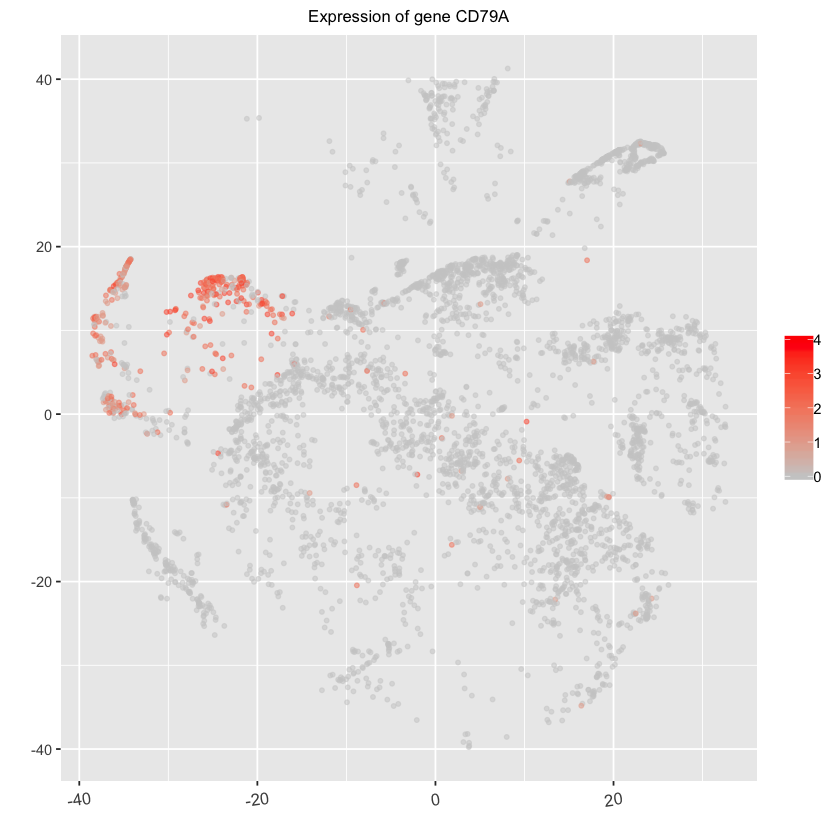

In [8]:
samples_expressions = left_join(samples, expressions, by=c("Barcode"="metadata.Run Source ID"))
samples_expressions[is.na(samples_expressions[['expression']]), 'expression'] = 0
ggplot(samples_expressions, mapping=aes(x=x, y=y, color=expression)) +
    geom_point(cex=1, alpha=0.5) +
    theme(axis.text.x = element_text(size = 10, angle = 8, hjust = 0.5, vjust = 0.5)) +
    theme(legend.title = element_blank()) + labs(y = "", x = "") + 
    scale_colour_gradient(low="grey80", high="red") +
    ggtitle(sprintf('Expression of gene %s', gene)) + theme(plot.title = element_text(hjust = 0.5, size=10))